In [43]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import argparse
import os.path
import sys
import time
import subprocess
import math 
import os
import random
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import csv
import sklearn
from sklearn.cluster import MeanShift, estimate_bandwidth, KMeans, Birch
from sklearn.decomposition import PCA, FastICA, TruncatedSVD
import numpy as np
from scipy.spatial import distance_matrix
from scipy.spatial.distance import cosine

from sklearn.preprocessing import normalize


In [46]:
modelList = ["E:/CASP13/data/CASP11_stage1/MODELS/" + p+"/res.txt" for p in os.listdir("E:/CASP13/data/CASP11_stage1/MODELS/")] + \
            ["E:/CASP13/data/CASP12_stage1/MODELS/" + p+"/res.txt" for p in os.listdir("E:/CASP13/data/CASP12_stage1/MODELS/")]

# Run stride on all models to compute secondary structure and SASA

In [11]:
for resultFileName in modelList :
    if not os.path.isfile(resultFileName): continue
    with open(resultFileName) as f:
        content = f.readlines()
        startPDB = 0
    for i in range(len(content)) :
        if (content[i][0:3] != "RES"):
            ssFile = content[i][:-1]+".ss"
            if not os.path.isfile(ssFile):
                subprocess.call(
                  ["C:/Users/pages/Documents/CASP13/src/stride/build/Release/stride.exe",
                  "-f"+ssFile, content[i][:-1]])
                

# Read all results precomputed


In [12]:

resArray = []
for resultFileName in modelList :
    #resultFileName = "E:/CASP13/data/CASP11_stage1/MODELS/T0793/res.txt"
    print(resultFileName)
    if ".ipynb_checkpoints" in resultFileName: continue
    #if "T0818" in resultFileName : break
    if not os.path.isfile(resultFileName): continue
    with open(resultFileName) as f:
        content = f.readlines()
        startPDB = 0
    for i in range(len(content)) :
        if (content[i][0:3] != "RES"):
            ssFile = content[i][:-1]+".ss"
            with open(ssFile) as f:
                contentSS = [line for line in f.readlines() if line[:3] == "ASG"]
                startPDB = i+1
        else :
            try :
                #amino acid, ornateScore, surface area, secondary structure, [scoreBranch, importance]*22
                #resPoint = [ord(content[i][9]), float(content[i][10:17]), float(content[i][18:23]), ord(contentSS[i-startPDB][24])]+[float(v) for v in content[i][24:-1].split()]
                resPoint = [ord(content[i][9]), float(content[i][10:17]), float(contentSS[i-startPDB][61:69]),  ord(contentSS[i-startPDB][24]), int(contentSS[i-startPDB][11:16]),ssFile]+[float(v) for v in content[i][24:-1].split()]
                resArray.append(resPoint)
            except IndexError :
                print("error")
                #print(content[i])
                #print(contentSS)
                #print("rorre")
        

E:/CASP13/data/dummy/MODELS/T0659/res.txt
E:/CASP13/data/dummy/MODELS/T0759/res.txt


In [13]:
maxSurfArea_res={}

for resPoint in resArray :
    if not resPoint[0] in maxSurfArea_res:
        maxSurfArea_res[resPoint[0]]=[]
    maxSurfArea_res[resPoint[0]].append(resPoint[2])

In [14]:
np.mean(maxSurfArea_res[86])


60.512903225806454

In [15]:
np.amax(maxSurfArea_res[86])

151.5

# Maximum surface area per residue

In [16]:
maxSurfArea={
    ord('A'):129,
    ord('R'):274,
    ord('N'):195,
    ord('D'):193,
    ord('C'):167,
    ord('E'):223,
    ord('Q'):225,
    ord('G'):104,
    ord('H'):224,
    ord('I'):197,
    ord('L'):201,
    ord('K'):236,
    ord('M'):224,
    ord('F'):240,
    ord('P'):159,
    ord('S'):155,
    ord('T'):172,
    ord('W'):285,
    ord('Y'):263,
    ord('V'):174
    
}

In [17]:
resType_Route = np.zeros((100,22))
for resPoint in resArray : 
    for i in range(22):
        resType_Route[resPoint[0]][i] += resPoint[7+2*i]-0.01

In [18]:
resType_Route = [l for l in resType_Route if l[0]!=0]
for i in resType_Route : 
    print(np.sum(i))

34.6498
12.8694
41.5807
57.42
7.9204
51.479099999999995
46.529799999999994
44.55009999999999
38.61009999999999
42.569700000000005
18.810600000000004
23.759299999999996
25.7406
38.6093
32.67
60.38980000000001
15.839499999999997
61.3782
10.8899
13.859199999999998


In [19]:
routeImportance = np.sum(resType_Route, axis =0)
newOrder = range(len(routeImportance))
newOrder = [x for _,x in sorted(zip(-1*routeImportance,newOrder))]
print(routeImportance)
print(newOrder)

[3.76500e+01 3.59384e+01 8.87500e+01 1.68514e+01 9.81390e+00 5.53721e+01
 1.52020e+01 2.33946e+01 1.85726e+01 2.36710e+01 2.37328e+01 2.63170e+00
 3.11026e+01 7.87557e+01 8.43000e-02 2.61775e+01 5.25686e+01 2.08868e+01
 2.76605e+01 3.56431e+01 4.06642e+01 1.50017e+01]
[2, 13, 5, 16, 20, 0, 1, 19, 12, 18, 15, 10, 9, 7, 17, 8, 3, 6, 21, 4, 11, 14]


# Show relative importance of different routes
Note that two routes were used for debug purposes and are not considered

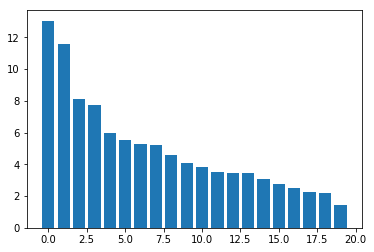

In [20]:
routeImportance[newOrder]/ np.sum(routeImportance)
plt.bar(range(20),routeImportance[newOrder[:20]]*100/ np.sum(routeImportance))
plt.show()

In [21]:
originalRes = ["A","C","D","E","F","G","H","I","K","L","M","N","P","Q","R","S","T","V","W","Y"]
clusteredResidues = ["C","F","Y","W","M","L","I","V","G","P","A","T","S","N","H","Q","E","D","R","K"]
clusterResidueOrder = [originalRes.index(x) for x in clusteredResidues]
resType_Route = normalize(resType_Route, axis=1, norm="l1")

In [22]:
importanceByPoint = [[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]]
scoreByPoint = [[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]]
for resPoint in resArray : 
    for i in range(22):
        importanceByPoint[i].append(resPoint[7+2*i]-0.01)
        scoreByPoint[i].append(resPoint[6+2*i])

In [23]:

importanceArrayOrdered= [ importanceByPoint[i] for i in newOrder]

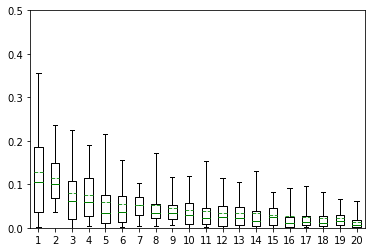

In [24]:
green_diamond = dict(color="g")
ax = plt.subplot()
plt.boxplot(importanceArrayOrdered[:20], whis=[5,95], showfliers=False, showmeans = True, meanline = True, medianprops = green_diamond)
ax.set_ylim(0,0.5)
plt.show()

In [25]:
import sys
!{sys.executable} -m pip install pandas

In [26]:
import pandas as pd
import seaborn as sns
from scipy.stats import gaussian_kde
from sklearn.utils import shuffle

In [27]:
%matplotlib notebook

# Score vs Weight per branch

0


<IPython.core.display.Javascript object>


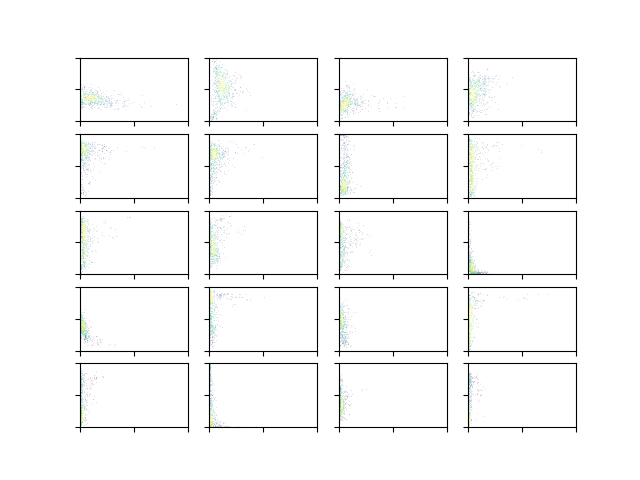

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [28]:
nbKDE=2500
gridRes=50
for i in range(20):
    print(i)
    ax = plt.subplot(5,4,i+1)
    x = importanceByPoint[newOrder[i]]
    y = (1+np.tanh(scoreByPoint[newOrder[i]]))/2
    x,y = shuffle(x,y,random_state=0)
    xykde = np.vstack([x[:nbKDE],y[:nbKDE]])
    xy = np.vstack([x,y])
    
    kde = gaussian_kde(xykde)
    gridxy=[np.tile(np.arange(0,1,1/gridRes), gridRes), np.repeat(np.arange(0,1,1/gridRes), gridRes)]
    z = kde(gridxy)
    colors = [z[int(gridRes*y[k])*gridRes+int(gridRes*x[k])] for k in range(len(x))]
    plt.scatter(x, y,  c=colors, marker='o', lw=0, s=(0.1))
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.yaxis.set_ticklabels([])
    ax.xaxis.set_ticklabels([])
plt.show()

# Script to find patterns
It creates a script to visualize in pymol putative patterns
Define branch, residue name, number of structures to visualize and whether you are looking for activator or suppressor patterns

In [29]:
def showMostScored(branchTest, residueName, nbToTest = 100, positive = True):
    oldOrder = -1
    for k in range(len(newOrder)):
        if newOrder[k]==branchTest-1:
            oldOrder=k
    maxImp=(np.amax(importanceByPoint[oldOrder]))
    maxImp=0
    for resPoint in resArray : 
        pointVal = resPoint[6+2*oldOrder] * resPoint[7+2*oldOrder]
        if chr(resPoint[0]) in residueName and pointVal>maxImp:
            maxImp=pointVal
            #print(resPoint)
    nbEx=25
    print(maxImp)
    targetImp=[maxImp * (i+60)/(nbEx+30) for i in range(nbEx)]
    targetResPoints=[resArray[0] for i in range(nbEx)]
    targetErrors=[maxImp for i in range(nbEx)]
    mult = 1 if positive else -1
    resVal = [mult* resPoint[6+2*oldOrder] *abs(resPoint[6+2*oldOrder]) * resPoint[7+2*oldOrder] if chr(resPoint[0]) in residueName else 0  for resPoint in resArray]
    
    list1, list2 = (list(t) for t in zip(*sorted(zip(resVal, resArray))))
    c=0
    tmpPyScipt= open("/tmp/tmpPyScript.py",'w')
    print('from pymol import cmd', file=tmpPyScipt)
    for t in list2[-nbToTest:]:
        name= format(c,'02d')
        print('cmd.load("' +t[5][:-3]+'","'+name+'")', file=tmpPyScipt)
        if c>0:
            print('cmd.align("', name,'and ((resi',t[4],'and name n+ca) or (resi',t[4]-1,'and name c))"," 00 and ((resi',list2[-nbToTest][4],'and name n+ca) or (resi',list2[-nbToTest][4]-1,'and name c))", matrix="ANY")', file=tmpPyScipt)
        print('cmd.select( "',name, ' beyond 9 of (00 and resi',list2[-nbToTest][4],')")', file=tmpPyScipt)
        print('cmd.remove( "sele','")', file=tmpPyScipt)
        
        #print('d=cmd.get_dihedral("'+name+'///'+str(t[4])+'/C","'+name+'///'+str(t[4])+'/CA","'+name+'///'+str(t[4])+'/CB","'+name+'///'+str(t[4])+'/CG or '+name+'///'+str(t[4])+'/CG1 or '+name+'///'+str(t[4])+'/SG")', file=tmpPyScipt)
        print("try:",file=tmpPyScipt)
        print(' d=cmd.get_dihedral("'+name+'///'+str(t[4]-1)+'/C","'+name+'///'+str(t[4])+'/N","'+name+'///'+str(t[4])+'/CA","'+name+'///'+str(t[4])+'/C or '+name+'///'+str(t[4])+'/CG1 or '+name+'///'+str(t[4])+'/SG")', file=tmpPyScipt)
        print("except CmdException: d=0; cmd.disable('"+name+"')",file=tmpPyScipt)
        print('print(d)', file=tmpPyScipt)
        print('if d < -135 or d>-45: cmd.disable("'+name+'")', file=tmpPyScipt)
        #print('set_color c_'+name,", [255,",c,",",c,"]")
        #print('color c_'+name+", "+name)
        c+=1
    print('cmd.center()', file=tmpPyScipt)
    print("DONE")

In [30]:
showMostScored(8,'G', 100, True)

0.105096
DONE


In [31]:
nbByType={}
for k in resArray:
    if not k[0] in nbByType:
        nbByType[k[0]]=1
    else :
        
        nbByType[k[0]]+=1
tot = 0
nbAtomByAminoAcid={
    'A':5,
    'G':4,
    'I':8,
    'L':8,
    'P':7,
    'V':7,
    'F':11,
    'W':14,
    'Y':12,
    'D':8,
    'E':9,
    'R':11,
    'H':10,
    'K':9,
    'S':6,
    'T':7,
    'C':6,
    'M':8,
    'N':8,
    'Q':9,
}
for k in nbByType:
    tot+=nbByType[k]*nbAtomByAminoAcid[chr(k)]
for k in nbByType:
    print(chr(k),":")
    print(100*nbByType[k]*nbAtomByAminoAcid[chr(k)]/tot)
    

A :
3.2371439141694416
V :
8.028116907140214
T :
2.0717721050684426
D :
6.215316315205327
G :
3.847576766555679
E :
9.655937846836848
Y :
3.1076581576026636
S :
6.770255271920089
L :
6.3633000369959305
K :
6.4927857935627085
Q :
6.4927857935627085
I :
6.659267480577136
N :
3.551609322974473
R :
6.714761376248613
M :
2.8116907140214575
W :
2.8486866444691086
C :
1.4428412874583796
P :
3.366629670736219
H :
8.694043655197929
F :
1.6278209396966334


# Plot route usage with amino acid type, secondary structure and rsa

<IPython.core.display.Javascript object>


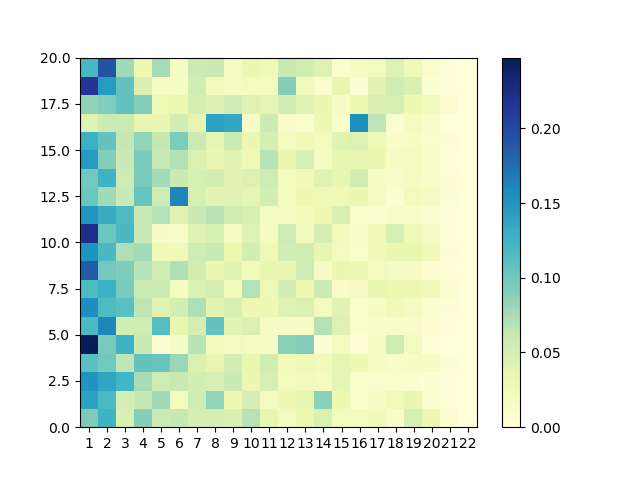

In [32]:

_,axes = plt.subplots()
plt.pcolormesh(resType_Route[:,newOrder], cmap=cm.YlGnBu)
#ax.set_aspect(1)

cbar = plt.colorbar()
#axes.set_yticks(np.arange(resType_Route.shape[0]) + 0.5, minor=False)
#axes.set_yticklabels(originalRes)

axes.set_xticks(np.arange(22)+0.5, minor=False)
axes.set_xticklabels(np.arange(22)+1)


plt.show()

In [33]:
secondaryStruct_route = np.zeros((100,22))
for resPoint in resArray : 
    for i in range(22):
        secondaryStruct_route[resPoint[3],i] += resPoint[7+2*i]-0.01
secondaryStruct_route[ord('B'),:] += secondaryStruct_route[ord('b'),:] 
secondaryStruct_route[ord('b'),:] *=0

<IPython.core.display.Javascript object>


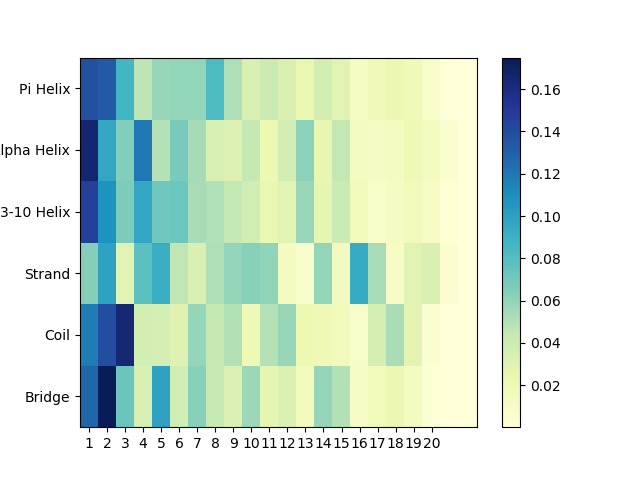

In [34]:

secondaryStruct_route = [l for l in secondaryStruct_route if l[0]!=0]
secondaryStruct_route = normalize(secondaryStruct_route, axis=1, norm="l1")

_,axes = plt.subplots()
plt.pcolormesh(secondaryStruct_route[:,newOrder] ,cmap=cm.YlGnBu)
#ax.set_aspect(1)

cbar = plt.colorbar()
axes.set_yticks(np.arange(secondaryStruct_route.shape[0]) + 0.5, minor=False)
axes.set_yticklabels(["Bridge", "Coil", "Strand", "3-10 Helix", "Alpha Helix", "Pi Helix", "Turn"])

axes.set_xticks(np.arange(20)+0.5, minor=False)
axes.set_xticklabels(np.arange(20)+1)



plt.show()

In [35]:
fullNess_route = np.zeros((120,22))
for resPoint in resArray : 
    for i in range(20):
        fullNess_route[int(resPoint[2]/maxSurfArea[resPoint[0]]*50)][i] += resPoint[7+2*i]-0.01
        #fullNess_route[int(resPoint[2]/maxSurfArea[ord('R')]*50)][i] += resPoint[5+2*i]-0.01
#fullNess_route[49]+=np.sum(fullNess_route[50:], axis =0)

<IPython.core.display.Javascript object>


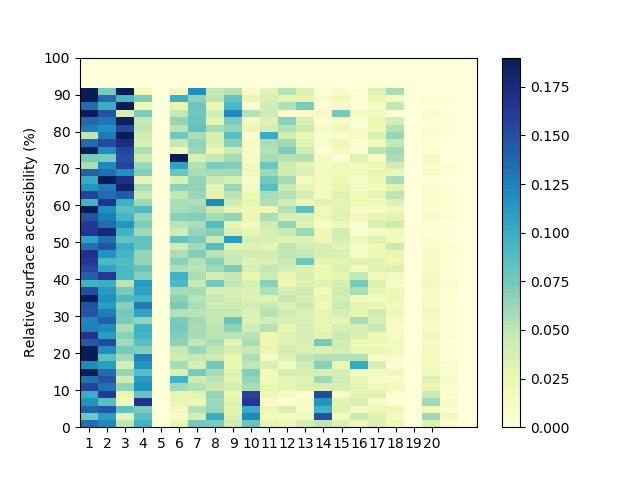

In [37]:
_,ax = plt.subplots()
fullNess_route_n = normalize(fullNess_route, axis=1, norm = "l1")

fullNess_route_n = np.minimum(fullNess_route_n,0.19)
#plt.pcolormesh(fullNess_route, cmap=cm.YlGnBu)
#ax.set_aspect(1)

#cbar = fig.colorbar(im)
fullNess_route_s = np.sum(fullNess_route, axis=1)

plt.pcolormesh(fullNess_route_n[0:50,newOrder], cmap=cm.YlGnBu)
ax.set_yticks(np.arange(11)*5, minor=False)
ax.set_yticklabels(np.arange(11)*10)
ax.set_ylabel("Relative surface accessibility (%)")

ax.set_xticks(np.arange(20)+0.5, minor=False)
ax.set_xticklabels(np.arange(20)+1)
plt.colorbar()
#plt.plot(fullNess_route_s)

plt.show()

# Cluster amino acids with respect to route usage

In [38]:
for nCluster in range(2,20):
    km = KMeans(n_clusters = nCluster, n_init = 100, random_state=1)
    km.fit(resType_Route)
    labels = km.labels_
    clusteredRes = [x for _,x in sorted(zip(labels,originalRes))]
    lab = sorted(labels)
    oldLabel = 0
    for i in range(len(clusteredRes)):
        if lab[i] != oldLabel : 
            print("|",end='')
            oldLabel = lab[i]
        print(clusteredRes[i],end='')
    print(" ")
    

AEPQRSTV|CDFGHIKLMNWY 
FMW|ACDEGHIKLNPQRSVY|T 
FMW|AEPQRS|CDGHIKLNVY|T 
CGIY|DHKLNV|AEPQRS|FMW|T 
CGY|FMW|AEPQRS|T|ILV|DHKN 
ILV|DHKN|AEPQRS|FMW|T|Y|CG 
DHKN|T|AEQRS|ILV|CG|FMW|Y|P 
AEQRS|DHKN|T|CG|F|ILV|Y|MW|P 
Y|AQ|ILV|DHKN|ERS|T|MW|CG|P|F 
CG|ERS|DHKN|T|MW|Y|AQ|IL|P|F|V 
HK|T|ERS|CG|Y|MW|V|IL|AQ|DN|P|F 
ERS|DN|M|T|IL|F|CG|HK|Y|V|AQ|P|W 
AQ|W|HK|T|IL|P|G|Y|F|V|ERS|C|M|DN 
DN|F|EQ|T|IL|P|G|M|Y|RS|A|W|C|V|HK 
T|HK|G|EQ|M|Y|F|V|P|I|A|W|C|RS|L|DN 
M|EQ|H|C|T|I|F|P|Y|A|W|V|RS|G|L|DN|K 
DN|T|H|RS|F|L|C|M|I|Y|A|V|W|P|Q|G|K|E 
G|W|S|T|L|Y|DN|F|A|K|P|I|V|M|H|C|Q|R|E 


<IPython.core.display.Javascript object>


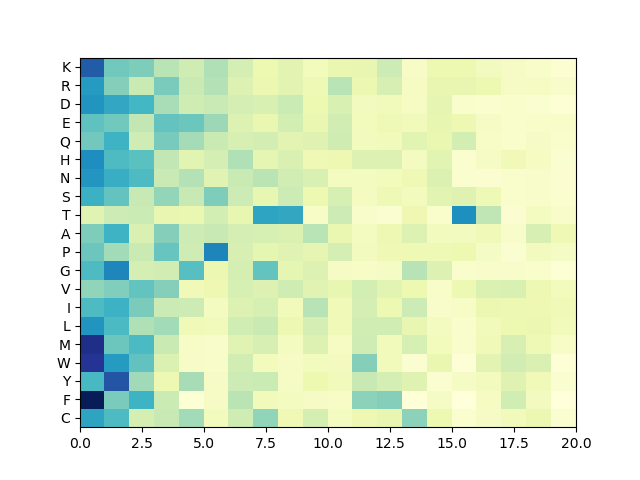

In [39]:

ax_aa = plt.subplot(111)
plt.pcolormesh(resType_Route[clusterResidueOrder,:][:,newOrder[:20]], cmap=cm.YlGnBu)
ax_aa.set_yticks(np.arange(resType_Route.shape[0]) + 0.5, minor=False)
ax_aa.set_yticklabels(clusteredResidues)
plt.show()

# Compare different clustering schemes

In [40]:
import clusim.sim as sim
import clusim as clu
from clusim.clustering import Clustering, print_clustering

DendroPY not supported.


In [41]:
cl1 = Clustering()
#                         F W Y M L I C V A P E D G N S T H K Q R
cl1.from_membership_list([0,0,0,0,1,1,1,1,2,2,2,3,3,3,3,3,4,4,4,4])
cl2 = Clustering()
cl2.from_membership_list([0,0,0,1,1,1,2,1,2,2,4,4,3,4,2,2,0,4,4,4])
cl3 = Clustering()
cl3.from_membership_list([0,0,0,4,4,0,2,0,4,1,4,2,3,2,2,2,2,4,4,4])
cl4 = Clustering()
cl4.from_membership_list([0,0,4,0,1,2,1,1,2,4,4,4,0,3,2,3,1,3,4,3])

In [42]:
print_clustering(cl1)
print(sim.jaccard_index(cl1,cl2))
print(sim.jaccard_index(cl1,cl3))
print(sim.jaccard_index(cl1,cl4))
print(sim.jaccard_index(cl2,cl3))
print(sim.jaccard_index(cl2,cl4))
print(sim.jaccard_index(cl3,cl4))

0123|4567|8910|1112131415|16171819
0.21428571428571427
0.2222222222222222
0.16981132075471697
0.22058823529411764
0.15254237288135594
0.06944444444444445
